# Creating the Chronos class

There should be a few specs for this method:

* Should have a scikit-learn like interface (fit, predict)
* Should have support for MLE, MAP, MCMC, and SVI
* Parameters should be easy to grab
* Should support arbitrary error distributions
* Should support censored data

In [1]:
import torch
import pyro

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pyro
import pyro.distributions as dist

# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS

In [2]:
my_ts_data = pd.read_csv('data/prophetData.csv')
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [3]:
my_ts_data.shape

(2905, 2)

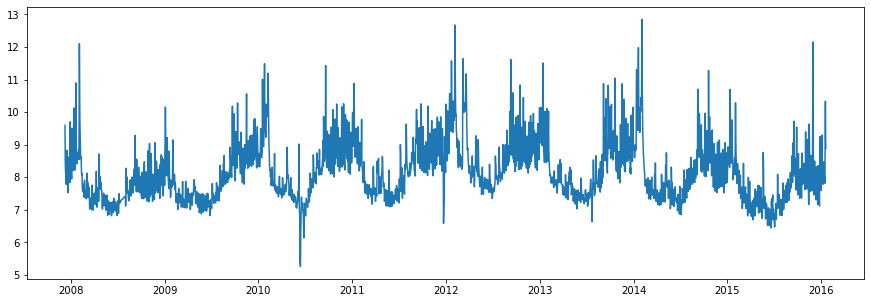

In [4]:
plt.figure(figsize=(15,5))
plt.plot(my_ts_data['ds'], my_ts_data['y'])
plt.show()

In [31]:


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

import torch
import pyro
import pyro.distributions as dist


# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS
from pyro.infer import SVI, Trace_ELBO, Predictive, JitTrace_ELBO
from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal

from torch.distributions import constraints

import warnings
import logging

pyro.enable_validation(True)

torch.set_default_tensor_type(torch.FloatTensor)
class Chronos:
    
    
    def __init__(self, 
                 method="MLE", 
                 time_col = "ds",
                 target_col="y", 
                 year_seasonality_order=10,
                 weekly_seasonality_order=3,
                 n_iter=1000):
        
        self.method_ = method
        self.n_iter_ = n_iter
        self.year_seasonality_order_ = year_seasonality_order
        self.weekly_seasonality_order_ = weekly_seasonality_order
        
        self.time_col_ = time_col
        self.target_col_ = target_col
        
        
        
    def transform_data(self, data):
        internal_data = data.copy()
        internal_data[self.time_col_] = internal_data[self.time_col_].values.astype(float)/(1e9*60*60*24)
        
        # Yearly seasonality 
        for i in range(1, self.year_seasonality_order_+1):
            internal_data[f"yearly_sin_{i}"] = np.sin(i*2*math.pi*internal_data[self.time_col_]/365.25)
            internal_data[f"yearly_cos_{i}"] = np.cos(i*2*math.pi*internal_data[self.time_col_]/365.25)
            
        # Weekly seasonality
        for i in range(1, self.weekly_seasonality_order_+1):
            internal_data[f"weekly_sin_{i}"] = np.sin(i*2*math.pi*internal_data[self.time_col_]/7)
            internal_data[f"weekly_cos_{i}"] = np.cos(i*2*math.pi*internal_data[self.time_col_]/7)
            
        internal_data.insert(0, "CONST", 1.0)
        
        return internal_data
        
        
        
        
    def fit(self, data):
        
        
        internal_data = self.transform_data(data)
        #display(internal_data)
        
        
        X = torch.tensor(internal_data.drop(self.target_col_, axis=1).values)
        y = torch.tensor(internal_data[self.target_col_].values)
        
        
        if (self.method_ in ["MLE", "MAP"]):
            if (self.method_ == "MLE"):
                print("Employing Maximum Likelihood Estimation")
                self.model = self.model_MLE
                self.guide = self.guide_MLE
                
            elif (self.method_ == "MAP"):
                print("Employing Maximum A Postiori")
                self.model = self.model_MAP
                self.guide = AutoDelta(self.model_MAP)
                
                
            self.train_point_estimate(self.model, 
                                      self.guide,
                                      X,
                                      y)
        elif (self.method == "MCMC"):
            print("Employing Markov Chain Monte Carlo")
        
            
            
    ##################################################################
    def train_MCMC(self, model, X, y, sample_num = 3000):
        pass
    
    ##################################################################
    def train_point_estimate(self, model, guide, X, y, lr=0.001):
        
        pyro.clear_param_store()
        
        adam = pyro.optim.ClippedAdam({"lr": lr, "clip_norm": 100.0})
        
        
        self.svi_ = SVI(model, 
                        guide, 
                        adam, 
                        loss=JitTrace_ELBO())
        
        
        print_interval = min(self.n_iter_//10, 1000)
        
        for step in range(self.n_iter_):
            
            loss = self.svi_.step(X, y)/y.shape[0]
            
            if (step % print_interval == 0):
                print(f"{step} - loss: {loss}")
        print(f"{step} - loss: {loss}")
            
    ##################################################################
    
    def model_MLE(self, X, y):
        '''
        beta_0 = pyro.param("beta_0", torch.tensor(0.0))
        beta_1 = pyro.param("beta_1", torch.tensor(0.0))
        
        sigma = pyro.param("sigma", torch.tensor(1.0), 
                           constraint = constraints.positive)
    
        mu = beta_0 + (beta_1 * ts)        
        with pyro.plate("data", y.size(0)):
            pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
            
        '''
            
        mu = 0
        for i in range(0, X.size(1)):
            beta_1 = pyro.param(f"beta_{i}", torch.tensor(0.0))
            
            mu += (beta_1 * X[:, i])
            
        
        sigma = pyro.param("sigma", 
                           torch.tensor(1.0), 
                           constraint = constraints.positive)
         
        
        with pyro.plate("data", X.size(0)):
            pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
            
        return mu
        
        
    
    def guide_MLE(self, X, y):
        pass
    
    
    ##################################################################
    
    def model_MAP(self, X, y):
        
        mu = 0
        for i in range(0, X.size(1)):
            beta_1 = pyro.sample(f"beta_{i}", dist.Normal(0.0, 10.0))
            
            mu += (beta_1 * X[:, i])
            
        #mu += beta_0
        
        sigma = pyro.sample("sigma", dist.HalfCauchy(1.0))
         
        
        with pyro.plate("data", X.size(0)):
            pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
            
        return mu
        
    
    ##################################################################
    def predict(self, data):
        internal_data = self.transform_data(data)
        #display(internal_data)
        
        
        X = torch.tensor(internal_data.drop(self.target_col_, axis=1).values)
        y = torch.tensor(internal_data[self.target_col_].values)
        
        if (self.method_ in ["MAP", "MLE"]):
            predictive = Predictive(model=self.model,
                                    guide=self.guide,
                                    num_samples=1,
                                    return_sites=("_RETURN",)) 

            samples = predictive(X, y)

            predictions = samples['_RETURN'].detach().numpy().reshape(-1)


            return predictions
        else:
            raise NotImplementedError(f"Did not implement .predict for {self.method_}")

        
        
        
    ##################################################################
    
    @property
    def intercept_(self):
        if (self.method_ == "MLE"):
            return pyro.param("beta_0").item()
        elif (self.method_ == "MAP"):
            return pyro.param("beta_0_val").item()

    @property
    def coef_(self):
        if (self.method_ == "MLE"):
            return pyro.param("beta_1").item()
        elif (self.method_ == "MAP"):
            return pyro.param("beta_1_val").item()
    
    

In [32]:
my_chronos = Chronos(method="MLE", n_iter=20000)
my_chronos.fit(my_ts_data)

Employing Maximum Likelihood Estimation
0 - loss: 34.39795512231372


<ipython-input-31-6bb7d63dfe89>:143: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  for i in range(0, X.size(1)):
<ipython-input-31-6bb7d63dfe89>:144: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  beta_1 = pyro.param(f"beta_{i}", torch.tensor(0.0))
<ipython-input-31-6bb7d63dfe89>:150: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this functio

1000 - loss: 7.1535463440308735
2000 - loss: 2.3895828154056753
3000 - loss: 3.2517109842573815
4000 - loss: 3.5056783357922376
5000 - loss: 2.6169324388738593
6000 - loss: 3.2745440696343797
7000 - loss: 3.4653495485233723
8000 - loss: 2.6095513289844625
9000 - loss: 3.303932018363308
10000 - loss: 3.4355433164468625
11000 - loss: 2.6044806485245466
12000 - loss: 3.3265151575541947
13000 - loss: 3.413424332073153
14000 - loss: 2.600931489338899
15000 - loss: 3.3437909406348383
16000 - loss: 3.3968697775859447
17000 - loss: 2.598404590283581
18000 - loss: 3.357009493098758
19000 - loss: 3.384408971075741
19999 - loss: 2.9589085187718362


In [33]:
predictions = my_chronos.predict(my_ts_data)

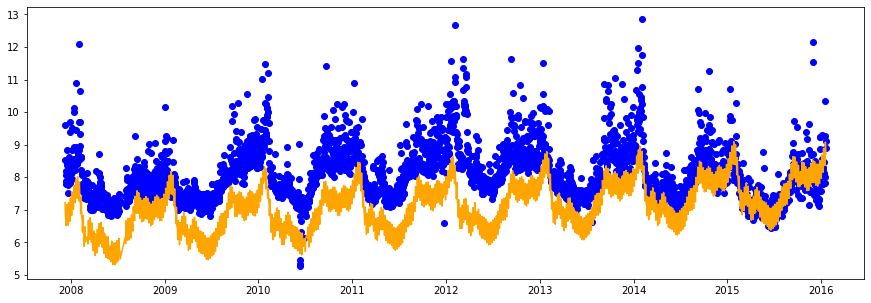

In [37]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.plot(my_ts_data['ds'], predictions, c="orange")
plt.show()